<h1> Unsupervised approach for text categorization </h1>
<p> Author: Mariia Ponomarenko </p>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Install necessary packages and **libraries**

In [ ]:
!pip install torch
!pip install transformers
!pip install sentence_transformers
!pip install keras
!pip install tensorflow
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 18.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.3 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=c42300e33ae1d5b10c0229e3f64cba1645947d0804cfc6817d605cae890a1f4b
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nltk
import re
import torch
import uuid
import os 
import csv
import pickle

from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer


from gensim.models import LdaModel, TfidfModel
from gensim.corpora import Dictionary

from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Read data


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
Path = 'drive/My Drive/data'

In [ ]:
initial_df = pd.read_csv(Path + '/' + 'projects_proposals.csv')

In [ ]:
initial_df.shape

(1118, 6)

In [ ]:
initial_df.head(5)

,Unnamed: 0,index,title,abstract,supervisor,company
0,0,0,adapting contextual bandit algorithms to adser...,contextual bandit algorithms are developed to ...,Leonard Wong,[24]7.ai
1,1,1,defending white box adversarial examples with ...,as deep neural networks become increasingly co...,Gennady Pekhimenko,AMD
2,2,2,modern gameplay test automation with reinforce...,gameplay testing on computer games to help ens...,Amir-massoud Farahmand,AMD
3,3,3,reducing data loading time in machine learning...,training of models in machine learning is typi...,Maryam Mehri Dehnavi,AMD
4,4,4,hybrid recommender system for applications bas...,collaborative filtering is a widely used metho...,Peter Marbach,AppDirect


In [ ]:
titles = initial_df["title"]

In [ ]:
newdf = initial_df.drop(["supervisor", "company"], axis='columns')

In [ ]:
newdf.head(5)

,Unnamed: 0,index,title,abstract
0,0,0,adapting contextual bandit algorithms to adser...,contextual bandit algorithms are developed to ...
1,1,1,defending white box adversarial examples with ...,as deep neural networks become increasingly co...
2,2,2,modern gameplay test automation with reinforce...,gameplay testing on computer games to help ens...
3,3,3,reducing data loading time in machine learning...,training of models in machine learning is typi...
4,4,4,hybrid recommender system for applications bas...,collaborative filtering is a widely used metho...


We need to make sure that indexes pair with number of rows.

In [ ]:
newdf = newdf.reset_index() 
newdf = newdf.drop(['index'], axis=1)

In [ ]:
newdf = newdf.drop(['level_0'], axis=1)

In [ ]:
newdf = newdf.drop(['Unnamed: 0'], axis=1)

In [ ]:
newdf

,title,abstract
0,adapting contextual bandit algorithms to adser...,contextual bandit algorithms are developed to ...
1,defending white box adversarial examples with ...,as deep neural networks become increasingly co...
2,modern gameplay test automation with reinforce...,gameplay testing on computer games to help ens...
3,reducing data loading time in machine learning...,training of models in machine learning is typi...
4,hybrid recommender system for applications bas...,collaborative filtering is a widely used metho...
...,...,...
1113,multilingual semantic similarity of unstructur...,to communicate with their end users businesses...
1114,multilingual semantic search engine using mult...,multiple situations require crosslingual searc...
1115,revealing trends in quantum technology with na...,recent years have witnessed a surge of interes...
1116,adding extra constraints to an open platform f...,acculogic develops stateoftheart testers for s...


In [ ]:
newdf.shape

(1118, 2)

Take a look at the first row of the data.

In [ ]:
string = newdf["abstract"][1]
print(string)

as deep neural networks become increasingly common in security conscious applications such as selfdriving cars or malware detection protecting networks from manipulation by an attacker has become increasingly important however neural networks trained to classify images are vulnerable to mistakes caused by images imperceptibly altered by an adversary existing defences against adversarial examples either require extensive retraining as in adversarial training or have been shown to be ineffective against an adversary that is aware of the defense a white box adversary as in the case of many preprocessing defenses we show that a denoising neural network can be trained to provide white box defense extending previous work which showed effectiveness only against an adversary unaware of the defense our defense provides comparable clean and robust accuracy to adversarial training when applied to the model used to guide the denoiser during training additionally the denoiser was transferred to oth

## Data Preprocessing

### Remove punctuation and digits


In [ ]:
def remove_punctuation_and_digits_df(df):
    tokenizer = RegexpTokenizer(r'\w+')
    for index, row in df.iterrows():
        preprocessed_string = " ".join(tokenizer.tokenize(row['abstract'])) # remove punctuaion 
        preprocessed_string_without_digits = re.sub(r'\d+', '', preprocessed_string) # remove digits 
        preprocessed_string_without_digits_lowercase = preprocessed_string_without_digits.lower()
        df.at[index,'abstract'] = preprocessed_string_without_digits_lowercase
    return df

In [ ]:
preprocessed_df = remove_punctuation_and_digits_df(newdf)

In [ ]:
string = preprocessed_df["abstract"][1]
print(string)

as deep neural networks become increasingly common in security conscious applications such as selfdriving cars or malware detection protecting networks from manipulation by an attacker has become increasingly important however neural networks trained to classify images are vulnerable to mistakes caused by images imperceptibly altered by an adversary existing defences against adversarial examples either require extensive retraining as in adversarial training or have been shown to be ineffective against an adversary that is aware of the defense a white box adversary as in the case of many preprocessing defenses we show that a denoising neural network can be trained to provide white box defense extending previous work which showed effectiveness only against an adversary unaware of the defense our defense provides comparable clean and robust accuracy to adversarial training when applied to the model used to guide the denoiser during training additionally the denoiser was transferred to oth

### Remove stopwords

In [ ]:
def remove_stop_words_df(df):
    stop_words = set(stopwords.words('english'))
    for index, row in df.iterrows():
        word_tokens = word_tokenize(row['abstract'])
        filtered_sentence = []
        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w)
        df.at[index,'abstract'] = " ".join(filtered_sentence)
    return df

In [ ]:
preprocessed_stop_words_df = remove_stop_words_df(preprocessed_df)

We will leave almost unprocessed docs for BERT model.

In [ ]:
summaries_for_bert = preprocessed_stop_words_df['abstract']

In [ ]:
summaries_for_bert

0       contextual bandit algorithms developed gain ma...
1       deep neural networks become increasingly commo...
2       gameplay testing computer games help ensure hi...
3       training models machine learning typically don...
4       collaborative filtering widely used method rec...
                              ...                        
1113    communicate end users businesses regularly pro...
1114    multiple situations require crosslingual searc...
1115    recent years witnessed surge interests explori...
1116    acculogic develops stateoftheart testers short...
1117    casebank provides service called chronicx airl...
Name: abstract, Length: 1118, dtype: object

In [ ]:
string = preprocessed_stop_words_df["abstract"][1]

In [ ]:
print(string)

deep neural networks become increasingly common security conscious applications selfdriving cars malware detection protecting networks manipulation attacker become increasingly important however neural networks trained classify images vulnerable mistakes caused images imperceptibly altered adversary existing defences adversarial examples either require extensive retraining adversarial training shown ineffective adversary aware defense white box adversary case many preprocessing defenses show denoising neural network trained provide white box defense extending previous work showed effectiveness adversary unaware defense defense provides comparable clean robust accuracy adversarial training applied model used guide denoiser training additionally denoiser transferred models trained dataset provided increase robust accuracy average compared models defense investigation required defense transfers distinct image classification tasks model used guide training changes efficacy transferability 

### Apply POS Tagging 

#### Extract Adjectives

In [ ]:
def get_adjectives(df, column_name):
    for index, row in newdf.iterrows():
        adjectives_list = []
        tokens = nltk.word_tokenize(row[column_name])
        tags = nltk.pos_tag(tokens)
        adjectives_list = [word for word, pos in tags if (pos == 'JJ')]
    return adjectives_list

In [ ]:
adjectives_list = get_adjectives(preprocessed_stop_words_df, 'abstract')

In [ ]:
len(adjectives_list)

7

#### Leave only nouns and adjectives in a text

In [ ]:
def get_adjectives_and_nouns(df, column_name):
    for index, row in df.iterrows():
        tokens = nltk.word_tokenize(row[column_name])
        tags = nltk.pos_tag(tokens)
        nouns = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS' or pos == 'JJ')]
        new_str = " ".join(nouns)
        df.at[index,column_name] = new_str 
    return df

In [ ]:
preprocessed_stop_words_adjectives_nouns_df = get_adjectives_and_nouns(preprocessed_stop_words_df, 'abstract')

In [ ]:
print(preprocessed_stop_words_adjectives_nouns_df["abstract"][1])

deep neural networks common security conscious applications cars malware detection networks manipulation attacker important neural networks classify images vulnerable mistakes images adversary defences adversarial examples extensive adversarial ineffective adversary aware defense white box adversary case many defenses neural network white box defense previous work effectiveness adversary unaware defense defense comparable clean robust accuracy adversarial training model transferred models dataset increase robust accuracy average models defense investigation defense transfers distinct image classification tasks model changes transferability white box adversarial examples denoiser


### Lemmatization

In [ ]:
def lemmatize_df(df, column_name):
    lemmatizer = WordNetLemmatizer()
    for index, row in preprocessed_stop_words_adjectives_nouns_df.iterrows():
        tokens = nltk.word_tokenize(row[column_name])
        lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
        new_str = " ".join(lemmatized_words)
        df.at[index,column_name] = new_str
    return df

In [ ]:
preprocessed_stop_words_adjectives_nouns_lemmatized_df = lemmatize_df(preprocessed_stop_words_adjectives_nouns_df, "abstract")

### Get *Abstract* column

In [ ]:
def get_specific_column_from_df(df, column_name):
    column = []
    for index, row in df.iterrows():
        column.append(row[column_name].split())
    column = pd.Series(column)
    return column

In [ ]:
abstracts = get_specific_column_from_df(preprocessed_stop_words_adjectives_nouns_lemmatized_df, "abstract")

In [ ]:
abstracts

0       [contextual, bandit, algorithm, maximum, rewar...
1       [deep, neural, network, common, security, cons...
2       [gameplay, computer, game, high, performance, ...
3       [training, model, machine, dividing, dataset, ...
4       [collaborative, filtering, method, recommendat...
                              ...                        
1113    [communicate, end, user, business, document, l...
1114    [multiple, situation, crosslingual, searching,...
1115    [recent, year, surge, interest, research, dire...
1116    [acculogic, stateoftheart, tester, electronic,...
1117    [casebank, service, chronicx, airline, industr...
Length: 1118, dtype: object

### Get Bigrams and Trigrams

In [ ]:
def get_bigrams_and_bigram_scores(column, frequency_filter): 
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_documents(column)
    finder.apply_freq_filter(frequency_filter)
    bigram_scores = finder.score_ngrams(bigram_measures.pmi)
    bigrams = [" ".join(list(bigram[0])) for bigram in bigram_scores]
    return bigram_scores, bigrams

In [ ]:
frequency_filter = 30
bigram_scores, bigrams = get_bigrams_and_bigram_scores(abstracts, frequency_filter)

In [ ]:
bigram_scores

[(('soti', 'snap'), 9.54280387742919),
 (('artificial', 'intelligence'), 9.094337800451903),
 (('natural', 'language'), 8.328607221298153),
 (('deep', 'learning'), 8.00229221293787),
 (('computer', 'vision'), 7.892055327356491),
 (('industrial', 'partner'), 7.566178385802999),
 (('language', 'processing'), 7.432488365125032),
 (('partner', 'organization'), 7.337512774520045),
 (('neural', 'network'), 7.23500595137949),
 (('mobile', 'device'), 6.366686306729285),
 (('recommender', 'system'), 6.30760661467907),
 (('machine', 'learning'), 6.000418582751294),
 (('big', 'data'), 5.4906466017149285),
 (('user', 'experience'), 5.1634771466257305),
 (('data', 'mining'), 4.649476340583266),
 (('objective', 'project'), 4.4532525098709534),
 (('machine', 'algorithm'), 4.436086374133648),
 (('goal', 'project'), 4.401290845782931),
 (('learning', 'model'), 4.325614714083446),
 (('machine', 'technique'), 4.240132317543392),
 (('research', 'project'), 3.7968734363590926)]

In [ ]:
def get_trigrams_and_trigram_scores(column, frequency_filter): 
  trigram_measures = nltk.collocations.TrigramAssocMeasures()
  finder_trigram = nltk.collocations.TrigramCollocationFinder.from_documents(column)
  finder_trigram.apply_freq_filter(frequency_filter)
  trigram_scores = finder_trigram.score_ngrams(trigram_measures.pmi)
  trigrams = [" ".join(list(trigram[0])) for trigram in trigram_scores]
  return trigrams, trigram_scores

In [ ]:
frequency_filter = 10
trigrams, trigram_scores = get_trigrams_and_trigram_scores(abstracts, frequency_filter)

In [ ]:
trigram_scores

[(('natural', 'language', 'processing'), 16.860631259974102),
 (('artificial', 'intelligence', 'ai'), 16.48460089430771),
 (('convolutional', 'neural', 'network'), 16.433199806111784),
 (('deep', 'neural', 'network'), 13.955152509307137),
 (('deep', 'learning', 'algorithm'), 13.225999954363086),
 (('deep', 'learning', 'model'), 12.115781199045042),
 (('machine', 'learning', 'model'), 10.8876751265142)]

In [ ]:
def get_trigrams(abstracts):
    trigrams = []
    whole_text = []
    for abstract in abstracts:
        whole_text = whole_text + abstract

    ngrams = Counter(nltk.ngrams(whole_text, 3))

    for ngram, freq in ngrams.most_common(11):
        print(ngram, freq)
        trigrams.append(" ".join(ngram))
    return trigrams

In [ ]:
trigrams_another_method = get_trigrams(abstracts)

('natural', 'language', 'processing') 34
('machine', 'learning', 'model') 16
('convolutional', 'neural', 'network') 13
('deep', 'neural', 'network') 12
('artificial', 'intelligence', 'ai') 12
('deep', 'learning', 'model') 11
('deep', 'learning', 'algorithm') 11
('generative', 'adversarial', 'network') 9
('electronic', 'health', 'record') 9
('artificial', 'intelligence', 'machine') 9
('goal', 'research', 'project') 8


### Replace Ngrams with one word
Replace n-grams with one word (e.g. machine learning -> machine_learning)

In [ ]:
def replace_ngram(x, ngram_array):
    for gram in ngram_array:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [ ]:
def preprocess_ngram_df(series_column):
  tokenized_docs = series_column.apply(lambda x : " ".join(word for word in x))
  tokenized_docs = tokenized_docs.apply(lambda x: replace_ngram(x, bigrams))
  tokenized_docs = tokenized_docs.apply(lambda x: replace_ngram(x, trigrams))
  tokenized_docs = tokenized_docs.apply(lambda x: x.split())
  return tokenized_docs

In [ ]:
tokenized_docs = preprocess_ngram_df(abstracts)

In [ ]:
tokenized_docs

0       [contextual, bandit, algorithm, maximum, rewar...
1       [deep, neural_network, common, security, consc...
2       [gameplay, computer, game, high, performance, ...
3       [training, model, machine, dividing, dataset, ...
4       [collaborative, filtering, method, recommendat...
                              ...                        
1113    [communicate, end, user, business, document, l...
1114    [multiple, situation, crosslingual, searching,...
1115    [recent, year, surge, interest, research, dire...
1116    [acculogic, stateoftheart, tester, electronic,...
1117    [casebank, service, chronicx, airline, industr...
Length: 1118, dtype: object

### Get vocabulary from words

In [ ]:
def form_vocab(tokenized_docs):
    vocab = set()
    for i in tokenized_docs:
        for j in i:
            vocab.add(j)
    return vocab

In [ ]:
vocab = form_vocab(tokenized_docs)

In [ ]:
len(vocab)

7480

### Visualize word occurencies in each text

In [ ]:
def visualize_word_occurencies(vocab, tokenized_docs):
    vocab_data = {i : [] for i in list(vocab)}
    word_occrencies_df = pd.DataFrame(vocab_data)

    for doc in tokenized_docs:
        word_occrencies_df = word_occrencies_df.append({i : doc.count(i) for i in list(vocab)}, ignore_index=True)
    word_occrencies_df = word_occrencies_df.transpose()
    return word_occrencies_df

In [ ]:
word_occurencies_df = visualize_word_occurencies(vocab, tokenized_docs)

In [ ]:
word_occurencies_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117
utilizes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
observability,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
diminish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
money,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
architechs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
word_occurencies_df.shape

(7480, 1118)

### Calculate frequencies from words

In [ ]:
def calc_frequences(vocab, data_df):
    words_frequences = {}
    words_frequences = dict.fromkeys(list(vocab), 0)
    for word in list(vocab):
        for i in data_df.loc[[word], :].sum():
            words_frequences[word] += i
    words_frequences = {k: v for k, v in sorted(words_frequences.items(), key=lambda item: item[1], reverse=True)}
    return words_frequences

In [ ]:
words_frequences = calc_frequences(vocab, word_occurencies_df)

In [ ]:
type(words_frequences)

dict

### Visualize most popular words

In [ ]:
def show_plot_most_popular_words(start, end, words_frequences):
    fig, ax = plt.subplots(figsize=(16,8))
    x = list(words_frequences.keys())[start:end]
    y = list(words_frequences.values())[start:end]
    ax.bar(range(len(x)), y)
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x, rotation='vertical')
    ax.set_title('Words frequences (excluding stop words)')
    ax.set_xlabel('Word');
    ax.set_ylabel('Number of occurences');
    plt.show()

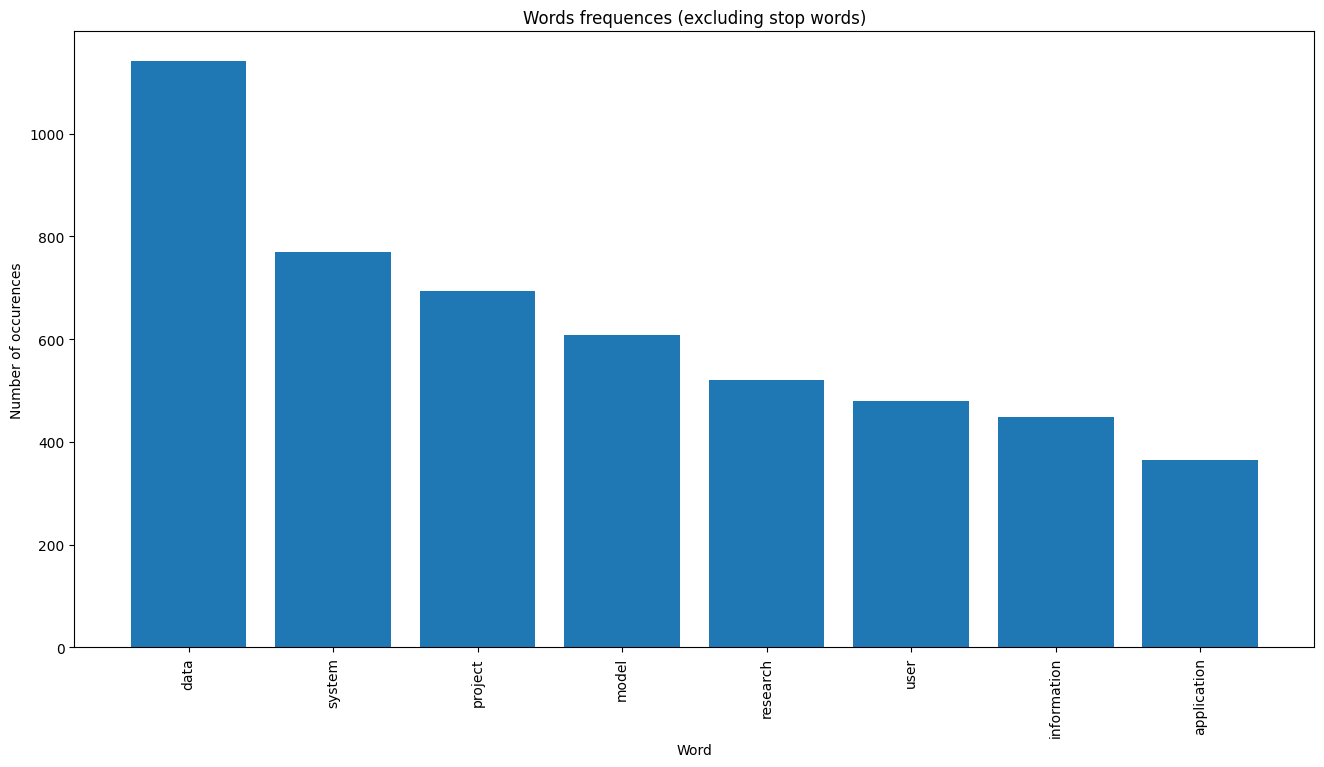

In [ ]:
start = 0
end = 8
show_plot_most_popular_words(start, end, words_frequences)

### Remove the most frequent words, adjectives and non-informative words

#### Create a set of unnecessary words

'https', 'github', 'com' are all non-informative words, as they can occur in every summary.

In [ ]:
remove_words = {'user', 'method', 'approach', 'result', 'model', 'data', 'problem', 'solution', 
'concept', 'task', 'work', 'process', 'step', 'goal', 'entity', 'aim', 'set', 'return', 'query', 'type','mission', 'knowledge','object', 'part', 'improvement','policy','insight', 
'frame','enhancement', 'measure', 'extraction', 'increase','factor', 'event', 'retrieval', 'book', 'version', 'ability', 'view',
 'stage', 'level', 'hair', 'subset', 'issue', 'custom', 'interest', 'show', 'g', 'gan', 'na', 'match', 'lack', 'ifit', 'million',
 'art', 'occurrence', 'student', 'capability', 'case', 'finding', 'https', 'github', 'com'}

Add more important words.

In [ ]:
important_words = {'robotics', 'cnn', 'machinelearning', 'kmeans', 'linguistic', 'aerospace', 'aircraft', 'logistics', 'transport', 
'timeseries', 'artificial', 'telematics', 'tomography', 'bert', 'gameplay', 'medicine', 'gaming', 'detector', 'forecast', 'robotic', 'android',
'genetic', 'statistic', 'cybersecurity', 'nlp', 'modelling', 'convolutional', 'textual'}

In [ ]:
def get_most_frequent_words(upper_percent, lower_percent, words_frequences, word_occurencies_df):
    number_of_docs = len(word_occurencies_df.columns)
    most_frequent_words = []
    for word in words_frequences.keys():
      if words_frequences[word] >= number_of_docs * upper_percent / 100 or words_frequences[word] <= number_of_docs * lower_percent / 100:
          most_frequent_words.append((word, words_frequences[word]))
    return most_frequent_words

In [ ]:
upper_percent = 50 
lower_percent = 2
most_frequent_words = get_most_frequent_words(upper_percent, lower_percent, words_frequences, word_occurencies_df)

In [ ]:
len(most_frequent_words)

6875

#### Update a set of unnecessary words with the most frequent words


In [ ]:
def update_remove_words_set(most_frequent_words, important_words, remove_words):
    for word in dict(most_frequent_words).keys():
        if word not in important_words:
            remove_words.add(word)
    return remove_words

In [ ]:
remove_words_updated = update_remove_words_set(most_frequent_words, important_words, remove_words)

In [ ]:
len(remove_words_updated)

6892

#### Update a set of unnecessary words with adjectives




In [ ]:
def create_remove_words_set(adjectives_list, remove_words):
    for i in adjectives_list:
      remove_words.add(i)
    return remove_words

In [ ]:
remove_words_with_adjectives = create_remove_words_set(adjectives_list, remove_words_updated)

In [ ]:
len(remove_words_with_adjectives)

6892

#### Delete unnecessary words from text

In [ ]:
len(vocab)

7480

In [ ]:
def delete_unnecessary_words_from_text(tokenized_docs, remove_words):
    for i in range(len(tokenized_docs)):
        for j in remove_words:
            tokenized_docs[i] = list(filter(lambda a: a != j, tokenized_docs[i]))
    return tokenized_docs

In [ ]:
tokenized_docs_deleted_words = delete_unnecessary_words_from_text(tokenized_docs, remove_words_with_adjectives)

In [ ]:
tokenized_docs_deleted_words

0       [algorithm, distribution, information, yield, ...
1       [deep, neural_network, common, security, appli...
2       [gameplay, computer, game, high, performance, ...
3       [training, machine, dataset, determine, parame...
4       [collaborative, recommendation, feedback, coll...
                              ...                        
1113    [end, business, document, various, language, r...
1114    [multiple, document, intelligence, mining, ope...
1115    [recent, year, research, technology, quantum, ...
1116    [stateoftheart, electronic, order, test, amoun...
1117    [service, industry, resolution, maintenance, r...
Length: 1118, dtype: object

Add additional stop words (they may occur in every abstract, which means they are not representatible)

In [ ]:
additional_stop_words = ["style", "choice", 'participant',"complicated", 'project', 
'performance', 'time', 'item', 'completion', 'path', 
'difficulty', 'future_work', 'purpose', 'reason', 'attention', 'transfer', 
'area', 'change', 'scene', 'removal', 'output', 'address', 'state', 'article', 
'control', 'source', 'limitation', 'manner', 'year', 'removal', 'augmentation', 'world', 
'challenge', 'fence', 'obstruction', 'ground', 'condensate', 'ab', 'experience', 
'b', 'leverage', 'fluency', 'similarity', 'planning', 'extract', "question", "context","essay", 
"outcome", "educator", 'advance','failure', 'library', 'input', 'reconstruction', 'yield',
'utterance', 'okta', 'usage', 'cpc', 'possibility', 'theme',"contract", "node", 
"identification", "city", "inference", "gap", "way", "internship", "field","success",
"background","importance","capture","medium","point","goal_project","risk","impact","measurement",
"code", "amount", "size", "focus", "term", "range", "property", "history", "experimen", 
"people", "benefit", "technique","end","presence", "target", 'age', 'practice', 'variety', 
'profile', 'edge', 'relationship', 'map', 'module', 'accuracy', 'domain', 'feedback', 'partner', 
'skill', 'aspect', 'effect', 'additional', 'collection', 'action', 'study', 
'activity','thing','number','function','day', 'collection', 
'core', 'variation', 'company', "business",'scale', 'combination', 'access', 
'demand', 'person', 'framework', 'behavior', 'gain', 
'requirement', 'role', 'today', "quality", "generation", "hand", "response", 
"communication", "resource","error","order","life",'researcher',
'phase', 'rule', 'pattern', 'consumption', 'form', 'cost', 'research_project', 'information', 'technology', 'home', 'research',
'technical', 'interactive', 'scenario', 'important', 'educational', 'learning', 'canada', 'effective', 'university', 'active']

def update_tokenized_docs(tokenized_docs, stop_words):
    for i in range(len(tokenized_docs)):
        for j in stop_words:
            tokenized_docs[i] = list(filter(lambda a: a != j, tokenized_docs[i]))
    for i in range(len(tokenized_docs)):
        for j in range(len(tokenized_docs[i])):
            if tokenized_docs[i][j] == 'graphql' or tokenized_docs[i][j] == 'cpc':
                tokenized_docs[i][j] = 'graph'
            if tokenized_docs[i][j] == 'ml':
                tokenized_docs[i][j] = 'machine_learning'
            if tokenized_docs[i][j] == 'train':
                tokenized_docs[i][j] = 'training'
            elif tokenized_docs[i][j] == 'nlu' or tokenized_docs[i][j] == 'nlg':
                tokenized_docs[i][j] = 'natural_language'
    return tokenized_docs

In [ ]:
tokenized_docs_updated = update_tokenized_docs(tokenized_docs_deleted_words, additional_stop_words)

#### Update vocabulary and word frequencies

In [ ]:
updated_vocab = form_vocab(tokenized_docs_updated)

In [ ]:
len(updated_vocab)

460

In [ ]:
type(tokenized_docs_updated)

pandas.core.series.Series

In [ ]:
def calculate_frequencies(tokenized_docs):
    dummy_frame = {'summaries': tokenized_docs}
    dummy_df = pd.DataFrame(dummy_frame)
    for i, row in dummy_df.iterrows():
        dummy_df.at[i,'summaries'] = " ".join(dummy_df.loc[i, "summaries"])
    most_popular_words = Counter(" ".join(dummy_df["summaries"]).split()).most_common(100)
    return dict(most_popular_words)

In [ ]:
most_popular_words = calculate_frequencies(tokenized_docs_updated)

In [ ]:
word_occurencies_updated_df = visualize_word_occurencies(updated_vocab, tokenized_docs_updated)

In [ ]:
word_occurencies_updated_df.shape

(460, 1118)

In [ ]:
type(most_popular_words)

dict

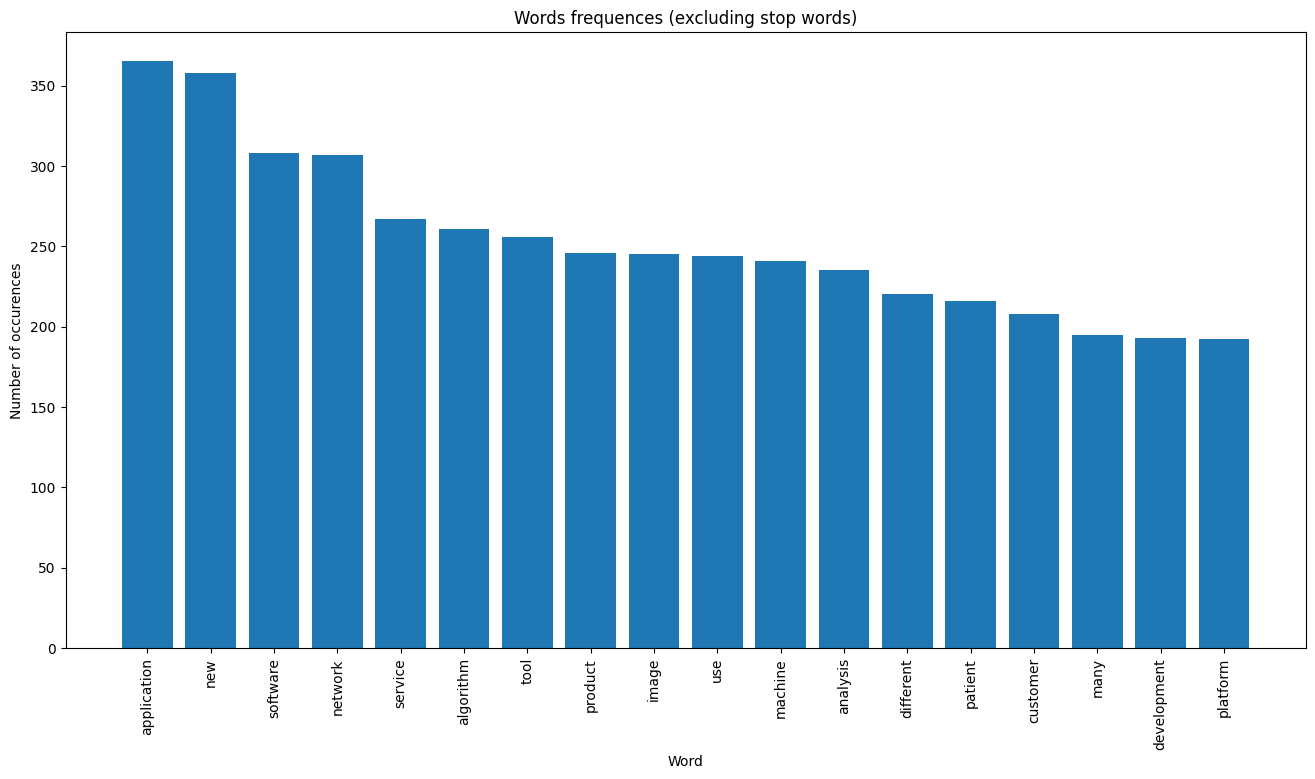

In [ ]:
start = 0
end = 18
show_plot_most_popular_words(start, end, most_popular_words)

## BERT + LDA + K-Means + t-SNE 

Idea: Concatenated both BERT and LDA vectors with a weight hyperparameter to balance the relative importance of information from each source.

### BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
original_tokenized_docs = summaries_for_bert.apply(lambda x: " ".join(x))

In [ ]:
prepared_docs_for_tokenizer = summaries_for_bert.apply(lambda x: "[CLS] " + x + " [SEP]")

In [ ]:
bert_tokenized_docs = prepared_docs_for_tokenizer.apply(lambda x: tokenizer.tokenize(x))

In [ ]:
len(bert_tokenized_docs)

1118

In [ ]:
bert_tokenized_docs

0       [[CLS], context, ##ual, bandit, algorithm, max...
1       [[CLS], deep, neural, network, common, securit...
2       [[CLS], gameplay, computer, game, high, perfor...
3       [[CLS], training, model, machine, dividing, da...
4       [[CLS], collaborative, filtering, method, reco...
                              ...                        
1113    [[CLS], communicate, end, user, business, docu...
1114    [[CLS], multiple, situation, cross, ##ling, ##...
1115    [[CLS], recent, year, surge, interest, researc...
1116    [[CLS], acc, ##ulo, ##gic, state, ##oft, ##hea...
1117    [[CLS], case, ##bank, service, chronic, ##x, a...
Name: abstract, Length: 1118, dtype: object

In [ ]:
model = SentenceTransformer('all-mpnet-base-v2')
bert_embeddings = model.encode(bert_tokenized_docs, show_progress_bar=True) # embeddings for summaries

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
bert_embeddings.shape

(1118, 768)

### LDA

Unlike in BERT, we feed preprocessed data in LDA. get_lda_embeddings(tokenized_docs, num_topics) returns a matrix whose rows are documents and columns are topics with some probability.

In [ ]:
def get_lda_embeddings(tokenized_docs, num_topics):
    dictionary = Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(text) for text in tokenized_docs]
    lda_model_bert = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary) 
    n_doc = len(corpus)
    vec_lda = np.zeros((n_doc, num_topics))
    for i in range(len(corpus)):
        for topic, prob in lda_model_bert.get_document_topics(corpus[i]):
            vec_lda[i, topic] = prob
    return vec_lda, lda_model_bert

In [ ]:
num_topics = 30
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]
lda_model_bert = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary) 
n_doc = len(corpus)
vec_lda = np.zeros((n_doc, num_topics))
for i in range(len(corpus)):
    for topic, prob in lda_model_bert.get_document_topics(corpus[i]):
        vec_lda[i, topic] = prob

In [ ]:
def get_lda_embeddings_existing(tokenized_docs):
    dictionary = Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(text) for text in tokenized_docs]
    n_doc = len(corpus)
    vec_lda = np.zeros((n_doc, num_topics))
    for i in range(len(corpus)):
        for topic, prob in lda_model_bert.get_document_topics(corpus[i]):
            vec_lda[i, topic] = prob
    summaries_for_bert = tokenized_docs.apply(lambda x: " ".join(x))
    original_tokenized_docs = summaries_for_bert.apply(lambda x: " ".join(x))
    prepared_docs_for_tokenizer = summaries_for_bert.apply(lambda x: "[CLS] " + x + " [SEP]")
    bert_tokenized_docs = prepared_docs_for_tokenizer.apply(lambda x: tokenizer.tokenize(x))
    gamma = 15
    bert_embeddings = model.encode(bert_tokenized_docs, show_progress_bar=True)
    vec_ldabert = np.c_[vec_lda * gamma, bert_embeddings]
    return vec_ldabert

In [ ]:
num_topics = 30
vec_lda, lda_model_bert = get_lda_embeddings(tokenized_docs_updated, num_topics)

In [ ]:
vec_lda.shape

(1118, 30)

### Combine LDA and BERT with fixed parameter *gamma*

In [ ]:
gamma = 15
vec_ldabert = np.c_[vec_lda * gamma, bert_embeddings]

### K-Means

In [ ]:
num_topics = 30 
kmeans = KMeans(n_clusters=num_topics)
kmeans_embed = kmeans.fit(vec_ldabert)

In [ ]:
kmeans_embed.labels_

array([19,  3, 28, ..., 12, 16,  6], dtype=int32)

In [ ]:
kmeans_embed.cluster_centers_

array([[ 1.13257813e-01,  1.08110065e-01,  2.26201789e-01, ...,
         8.66957246e-04, -1.67346672e-02, -1.85183348e-02],
       [-5.55111512e-17,  9.32744611e-02, -1.11022302e-16, ...,
        -1.62791682e-03, -1.79364292e-02, -1.82064664e-02],
       [ 9.63546336e-02,  2.69756607e-01, -5.55111512e-17, ...,
        -5.13320983e-03, -2.28590635e-02, -2.02727434e-02],
       ...,
       [-1.11022302e-16,  1.13292968e-01,  1.57089865e-01, ...,
        -4.32721914e-04, -2.09301607e-02, -2.07686962e-02],
       [ 1.42205372e-01,  3.70602245e-01,  0.00000000e+00, ...,
        -4.99574944e-03, -1.62636015e-02, -2.07507447e-02],
       [-1.66533454e-16,  6.53588550e-02, -2.77555756e-16, ...,
         6.38416361e-04, -2.07181012e-02, -2.05959313e-02]])

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 12.9 MB/s eta 0:00:00


In [ ]:
import shap

shap.initjs()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
kmeanModel = KMeans(n_clusters=30)
y = kmeanModel.fit(vec_ldabert).labels_
y1 = label_binarize(y, classes=[0 for i in range(30)])
clf=RandomForestClassifier()
clf.fit(vec_ldabert,y)

RandomForestClassifier()

In [ ]:
y

array([12,  6, 26, ...,  9,  4, 18], dtype=int32)

In [ ]:
vec_ldabert.shape

(1118, 798)

In [ ]:
def make_predictions(X_batch_text):
    X_batch_text = pd.Series(X_batch_text).apply(lambda x: x.split())
    li = get_lda_embeddings_existing(X_batch_text)
    preds = clf.predict(li)
    return preds

masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(make_predictions, masker=masker)

In [ ]:
X_batch_text = tokenized_docs_updated[1:3].apply(lambda x: " ".join(x))

shap_values = explainer(X_batch_text)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Partition explainer: 3it [00:53, 26.57s/it]


In [ ]:
tokenized_docs_updated[1:3]

1    [deep, neural_network, common, security, appli...
2    [gameplay, computer, game, high, graphic, many...
dtype: object

In [ ]:
classes = [0 for i in range(30)]

In [ ]:
shap_values[0]

.values =
array([-0.53125, -1.46875, -0.1875 , -1.6875 ,  2.875  ,  0.375  ,
        0.25   , -1.875  ,  0.21875, -0.40625,  3.53125, -0.96875,
        1.3125 , -1.375  ,  1.625  , -1.6875 ,  0.875  , -0.5    ,
       -1.     , -0.375  ,  0.15625,  1.03125,  2.96875, -2.90625,
       -3.3125 , -2.9375 ])

.base_values =
12.0

.data =
array(['deep ', 'neural_network ', 'common ', 'security ', 'application ',
       'detection ', 'network ', 'neural_network ', 'image ', 'image ',
       'adversarial ', 'example ', 'adversarial ', 'many ',
       'neural_network ', 'previous ', 'effectiveness ', 'robust ',
       'adversarial ', 'training ', 'dataset ', 'robust ', 'image ',
       'classification ', 'adversarial ', 'example'], dtype='<U15')

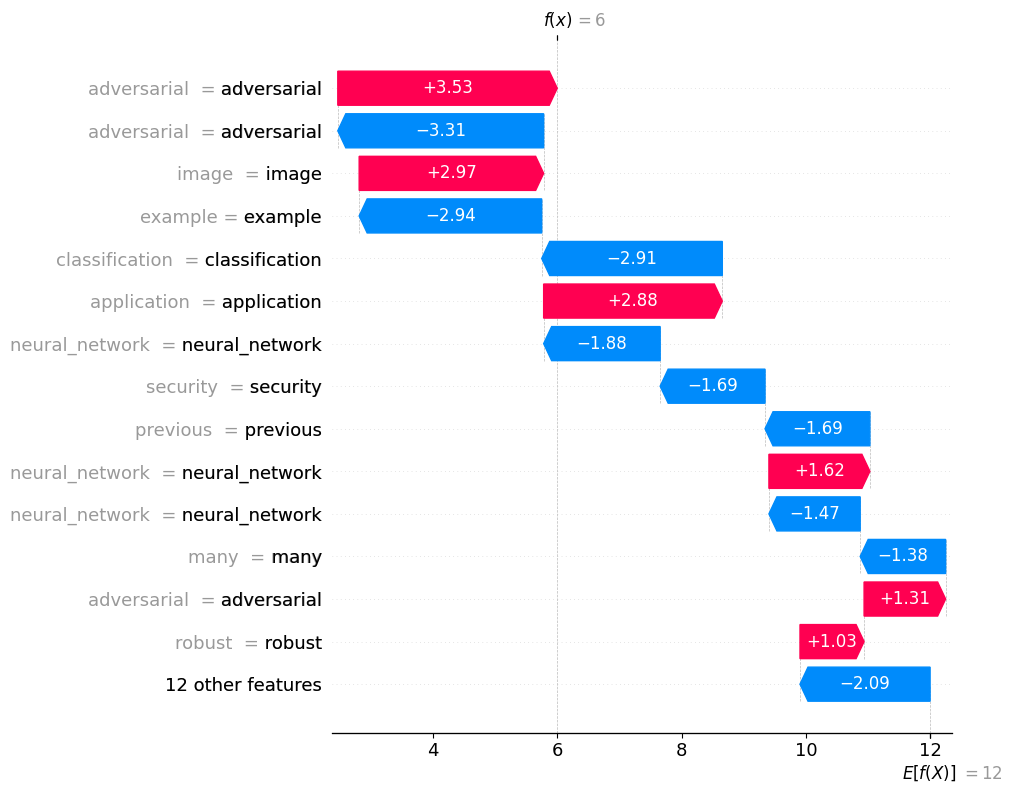

In [ ]:
shap.waterfall_plot(shap_values[0], max_display=15)

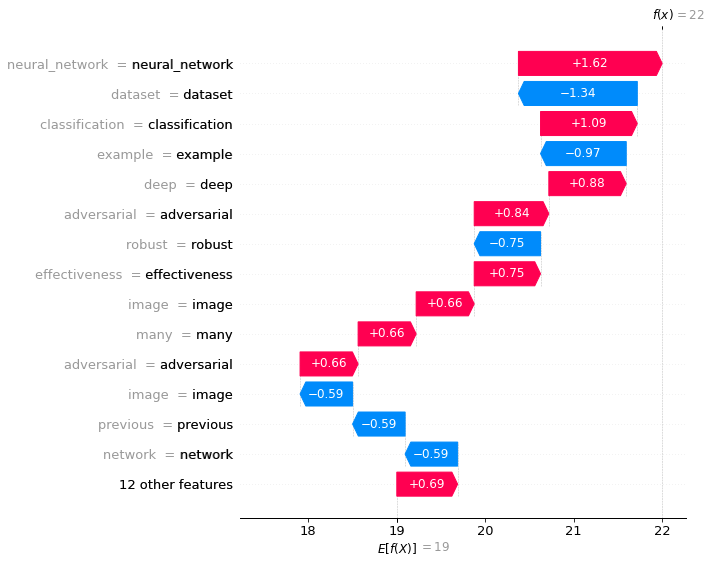

In [ ]:
shap.waterfall_plot(shap_values[0], max_display=15)

## Trying tf-idf features to run with Shap (in order to compare with PDD)

In [ ]:
bad_words = ['use', 'using', 'used', 'new', 'time', 'well']

In [ ]:
Path_for_tfidf_feature_vectors = 'drive/My Drive/Demo paper/feature_vectors/Mariia datasets/projects/tf_idf_feature_vectors1 - tf_idf_feature_vectors1.csv'
feature_vectors = pd.read_csv(Path_for_tfidf_feature_vectors, header=None)

In [ ]:
Path_for_tfidf_vocab = 'drive/My Drive/Demo paper/feature_vectors/Mariia datasets/projects/top_features_names_tf_idf_fixed.csv'
vocab = pd.read_csv(Path_for_tfidf_vocab, header=None)


In [ ]:
feature_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.0,0.0000,0.0541,0.0556,0.1710,0.0575,0.0000,0.0000,0.0,0.0000,...,0.0666,0.0000,0.0000,0.0000,0.068,0.0,0.000,0.0000,0.0,0.0689
1,0.0,0.0000,0.0000,0.0000,0.0000,0.1150,0.0582,0.0000,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.000,0.0,0.000,0.0685,0.0,0.0000
2,0.0,0.0414,0.0000,0.0871,0.0445,0.0000,0.0000,0.0000,0.0,0.0000,...,0.0522,0.1050,0.0526,0.0532,0.160,0.0,0.000,0.0537,0.0,0.0000
3,0.0,0.0000,0.0000,0.0000,0.0000,0.1190,0.0000,0.0000,0.0,0.0623,...,0.0000,0.0000,0.0000,0.0000,0.000,0.0,0.142,0.0000,0.0,0.0000
4,0.0,0.0439,0.0899,0.1850,0.0473,0.0478,0.1940,0.0491,0.0,0.0500,...,0.0000,0.0557,0.0000,0.0564,0.000,0.0,0.000,0.0000,0.0,0.0573


In [ ]:
feature_names = vocab[0].tolist()[1::]

In [ ]:
indexes_of_bad_words = [i for i in range(len(feature_names)) if feature_names[i] in bad_words]

In [ ]:
feature_vectors = feature_vectors.drop(columns=indexes_of_bad_words, axis=1)

In [ ]:
X = feature_vectors.values

In [ ]:
feature_names = [i for i in feature_names if i not in bad_words]

In [ ]:
kmeans = KMeans(n_clusters=35, random_state=6).fit(X)
labels = kmeans.labels_

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X, labels)

RandomForestClassifier()

In [ ]:
X.shape

(1118, 34)

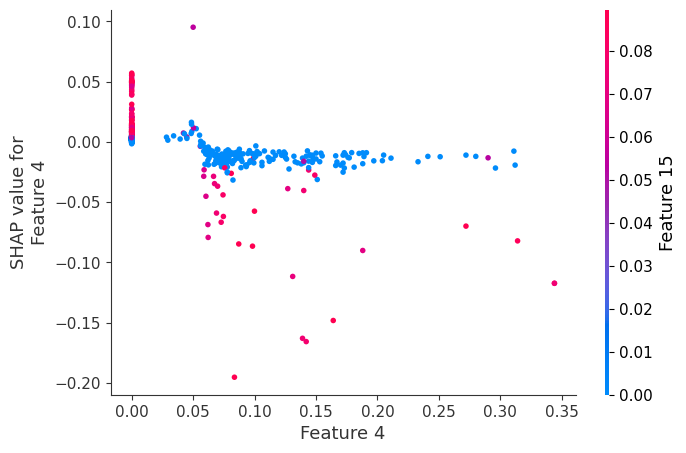

In [ ]:
# technology

shap.dependence_plot('Feature 4', shap_values[1], X)

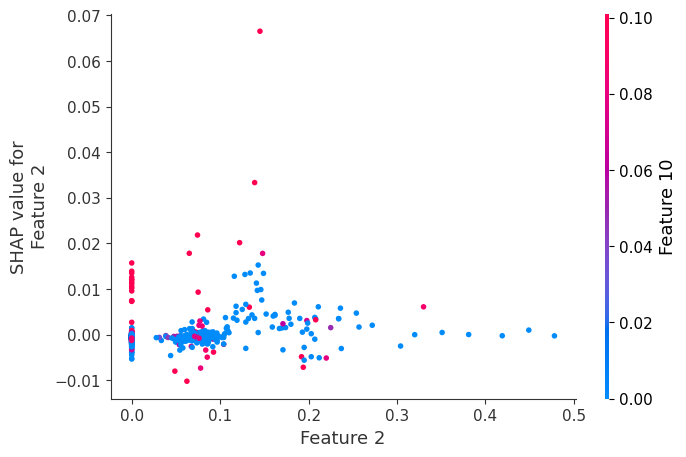

In [ ]:
# application

shap.dependence_plot('Feature 2', shap_values[0], X)

In [ ]:
len(shap_values)

35

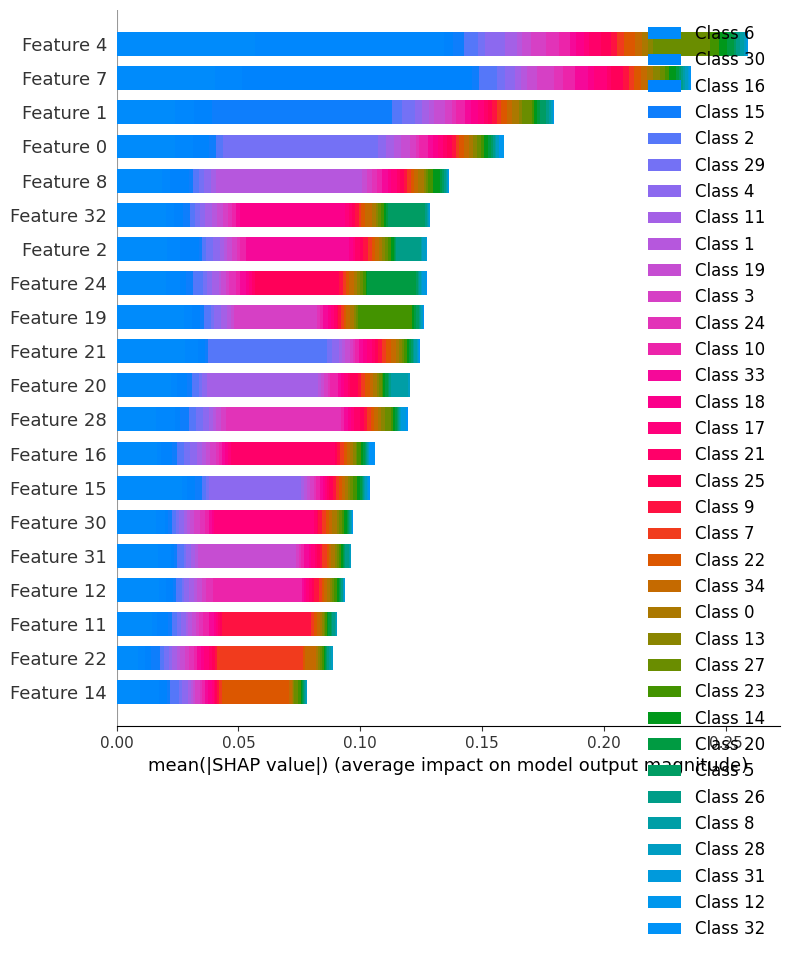

In [ ]:
shap.summary_plot(shap_values, X)

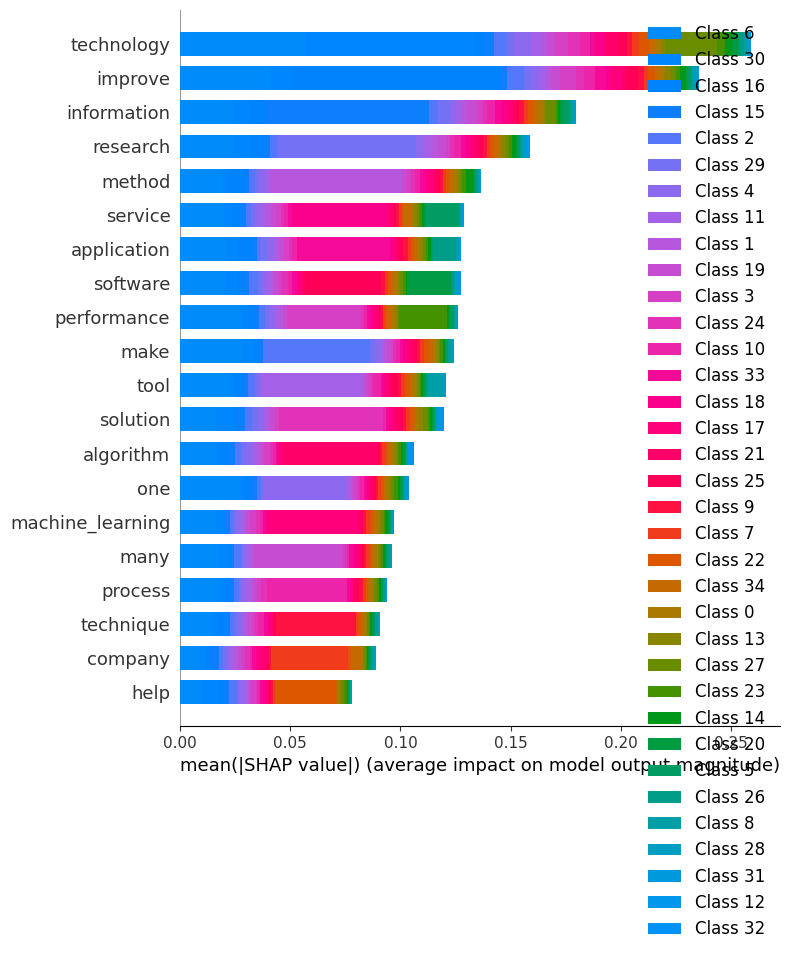

In [ ]:
shap.summary_plot(shap_values, X, feature_names=feature_names)

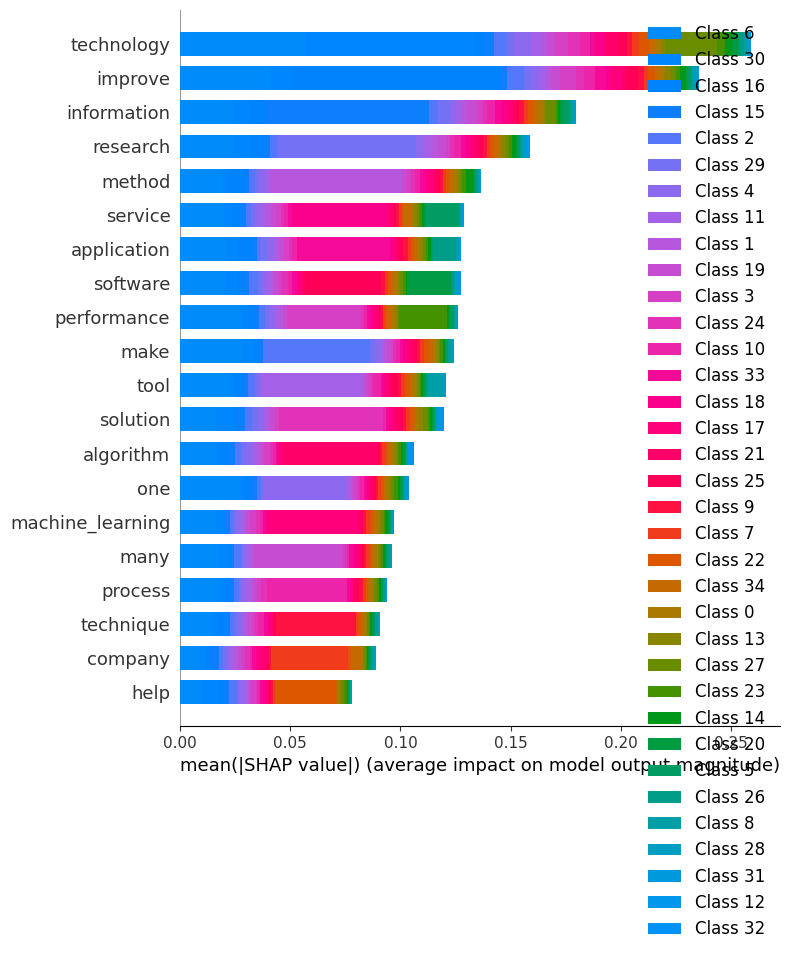

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

fig = plt.figure()
explainer = shap.TreeExplainer(rf)

# calculate shap values for the first two examples in X
shap_values = explainer.shap_values(X)

# plot the SHAP values
shap.summary_plot(shap_values, X, feature_names=feature_names)
plt.tight_layout()


plt.subplots_adjust(right=20)
plt.show()

### t-SNE

In [ ]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_ldabert = tsne_model.fit_transform(vec_ldabert)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1118 samples in 0.001s...
[t-SNE] Computed neighbors for 1118 samples in 0.129s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1118
[t-SNE] Computed conditional probabilities for sample 1118 / 1118
[t-SNE] Mean sigma: 3.239350
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.460426
[t-SNE] KL divergence after 1000 iterations: 0.342831


In [ ]:
tsne_ldabert_centers = tsne_model.fit_transform(kmeans_embed.cluster_centers_)

[t-SNE] Computing 29 nearest neighbors...
[t-SNE] Indexed 30 samples in 0.000s...
[t-SNE] Computed neighbors for 30 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 30 / 30
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.656296
[t-SNE] KL divergence after 1000 iterations: 0.464461


In [ ]:
def get_kmeans_labels_and_kmeans_centers(num_topics, y, tsne_ldabert, tsne_ldabert_centers):
    kmeans_labels = {i: [] for i in range(0, num_topics)}
    kmeans_centers = {i: 0 for i in range(0, num_topics)}
    for i in range(len(y.labels_)):
        kmeans_labels[y.labels_[i]].append([tsne_ldabert[i][0], tsne_ldabert[i][1]])
    for i in range(num_topics):
        kmeans_centers[i] = [tsne_ldabert_centers[i][0], tsne_ldabert_centers[i][1]]
    return kmeans_labels, kmeans_centers

In [ ]:
kmeans_labels, kmeans_centers = get_kmeans_labels_and_kmeans_centers(num_topics, kmeans_embed, tsne_ldabert, tsne_ldabert_centers)

In [ ]:
max(kmeans_embed.labels_)

29

In [ ]:
def get_kmeans_texts_and_kmeans_title(num_topics, kmeans_embed, tokenized_docs, titles):
    kmeans_texts = {i: [] for i in range(0, num_topics)}
    kmeans_title = {i: [] for i in range(0, num_topics)}
    for i in range(len(kmeans_embed.labels_)):
        kmeans_texts[kmeans_embed.labels_[i]].append(tokenized_docs[i])
        kmeans_title[kmeans_embed.labels_[i]].append(titles[i])
    return kmeans_texts, kmeans_title

In [ ]:
kmeans_texts, kmeans_title = get_kmeans_texts_and_kmeans_title(num_topics, kmeans_embed, tokenized_docs_updated, titles)

## Create new dataframe with topic

In [ ]:
type(kmeans_texts)

dict

In [ ]:
def get_kmeans_text_freqs(num_topics, kmeans_texts):
    kmeans_text_freqs = {i: {} for i in range(num_topics)}
    for i in kmeans_texts.keys():
        for j in range(len(kmeans_texts[i])):
            key_words = kmeans_texts[i][j]
            for c in key_words:
                if kmeans_text_freqs[i].get(c) == None:
                    kmeans_text_freqs[i][c] = 1
                else:
                    kmeans_text_freqs[i][c] += 1
    return kmeans_text_freqs

In [ ]:
kmeans_text_freqs = get_kmeans_text_freqs(num_topics, kmeans_texts)

In [ ]:
def get_words(ind, kmeans_text_freqs):
    s = ' '
    count = 0
    for k in kmeans_text_freqs[ind].keys():
        s += k + ", "
        count += 1
        if count == 5:
            s.rstrip(', ')
            break
    return s

In [ ]:
def create_new_dataframe(titles, tokenized_docs, kmeans_embed, kmeans_text_freqs):
    new_df = pd.DataFrame(columns=['Title', 'Abstract', 'Topic'])
    num_abstract_for_visualizing = 120
    for i in range(num_abstract_for_visualizing):
        new_dict = {'Title': titles[i], 'Abstract': tokenized_docs[i], 'Topic': get_words(kmeans_embed.labels_[i], kmeans_text_freqs)}
        new_df = new_df.append(new_dict, ignore_index=True)
    return new_df

In [ ]:
new_df = create_new_dataframe(titles, tokenized_docs_updated, kmeans_embed, kmeans_text_freqs)

In [ ]:
new_df.head(10)

,Title,Abstract,Topic
0,adapting contextual bandit algorithms to adser...,"[algorithm, distribution, several, new, algori...","algorithm, distribution, several, new, recent,"
1,defending white box adversarial examples with ...,"[deep, neural_network, common, security, appli...","deep, neural_network, common, security, appli..."
2,modern gameplay test automation with reinforce...,"[gameplay, computer, game, high, graphic, many...","gameplay, computer, game, high, graphic,"
3,reducing data loading time in machine learning...,"[training, machine, dataset, determine, parame...","training, machine, dataset, determine, parame..."
4,hybrid recommender system for applications bas...,"[collaborative, recommendation, collaborative,...","collaborative, recommendation, new, recommend..."
5,apifuzz introspection assisted fuzzer for qnx ...,"[realtime, critical, local, critical, applicat...","realtime, critical, local, application, inter..."
6,taking the first steps towards building a hard...,"[modern, software, efficient, complexity, comp...","training, machine, dataset, determine, parame..."
7,automated domain specific essay scoring,"[complex, significant, education, complete, so...","complex, significant, education, complete, so..."
8,secure crossservice genomic data federated ana...,"[health, complex, large, datasets, clinical, r...","health, complex, large, datasets, clinical,"
9,forecasting future fundamental metrics from ea...,"[management, public, financial, report, variou...","gameplay, computer, game, high, graphic,"


In [ ]:
for i in kmeans_text_freqs:
    kmeans_text_freqs[i] = {k: v for k, v in sorted(kmeans_text_freqs[i].items(), key=lambda item: item[1], reverse=True)[:5]}

In [ ]:
kmeans_text_freqs

{0: {'recommendation': 21,
  'help': 13,
  'product': 12,
  'management': 10,
  'feature': 10},
 1: {'patient': 60,
  'decision': 30,
  'clinical': 24,
  'representation': 23,
  'medical': 20},
 2: {'network': 126,
  'customer': 69,
  'service': 54,
  'security': 46,
  'software': 38},
 3: {'health': 44, 'security': 27, 'many': 25, 'new': 25, 'application': 22},
 4: {'algorithm': 28,
  'new': 15,
  'application': 14,
  'industry': 14,
  'management': 13},
 5: {'image': 43,
  'network': 35,
  'product': 31,
  'application': 27,
  'customer': 27},
 6: {'platform': 25,
  'application': 21,
  'current': 18,
  'development': 16,
  'tool': 15},
 7: {'patient': 59, 'web': 22, 'covid': 19, 'health': 17, 'service': 16},
 8: {'new': 21, 'camera': 19, 'algorithm': 16, 'asset': 15, 'image': 14},
 9: {'customer': 20,
  'new': 14,
  'management': 11,
  'network': 11,
  'industry': 9},
 10: {'algorithm': 16,
  'search': 14,
  'environment': 13,
  'human': 12,
  'customer': 11},
 11: {'application': 5

In [ ]:
colors =  ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
        
        "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
        "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
        "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
        "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
        "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
        "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
        "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
        "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"]

In [ ]:
len(colors)

128

In [ ]:
type(kmeans_title)

dict

In [ ]:
kmeans_title

{0: ['learning controllable directions of gan space',
  'learning latent representations in speech for data augmentation',
  'weakly supervised named entity recognition',
  'endtoend machine learning pipeline for harsh accident detection',
  'istandardize recommendations for healthcare form standardization',
  'predictive analytics for charitable giving',
  'biomass estimation form footage of single camera by applying deep learning algorithms',
  'machine learning methods for nova scotia property value prediction',
  'identification of highfrequency periodic acoustic fish tags with deep learning',
  'effective simulation and surface reconstruction approaches for detailed fluid simulation visual effects',
  'vrbased testing station for impairment screening',
  'data analysis and image processing for livestock identification',
  ' live id for livestock',
  'extracting information from emails',
  'collaborative service robot in a group home environment of people with developmental disabil

In [ ]:
def create_dataframe_topic_title_keywords(num_topics, kmeans_text_freqs, kmeans_title, titles):
    doc_topics = []
    se = set()
    for i in range(num_topics):
        topic = get_words(i, kmeans_text_freqs)
        for j in range(len(kmeans_labels[i])):
            p = {}
            if kmeans_title[i][j] in list(titles[:108]) and (kmeans_title[i][j] not in se):
                p['Topic'] = topic
                se.add(kmeans_title[i][j])
                p['Title'] = kmeans_title[i][j]
                p['Doc_keywords'] = kmeans_texts[i][j]
                doc_topics.append(p)
    df = pd.DataFrame(doc_topics)
    return df

In [ ]:
topic_title_keywords_df = create_dataframe_topic_title_keywords(num_topics, kmeans_text_freqs, kmeans_title, titles)

In [ ]:
topic_title_keywords_df

,Topic,Title,Doc_keywords
0,"recommendation, help, product, management, fe...",learning controllable directions of gan space,"[adversarial, network, capable, image, latent,..."
1,"recommendation, help, product, management, fe...",learning latent representations in speech for ...,"[investment, management, client, due, environm..."
2,"recommendation, help, product, management, fe...",weakly supervised named entity recognition,"[label, prediction, several, many, machine, tr..."
3,"recommendation, help, product, management, fe...",endtoend machine learning pipeline for harsh a...,"[safety, customer, canadian, global, telematic..."
4,"recommendation, help, product, management, fe...",istandardize recommendations for healthcare fo...,"[natural_language_processing, nlp, clinical, n..."
...,...,...,...
103,"image, mobile, blood, camera, design,",hardware aware neural architecture search for ...,"[simulation, reality, semantic, segmentation, ..."
104,"image, mobile, blood, camera, design,",learningbased obstruction removal,"[image, camera, modern, multiple, image, camer..."
105,"image, mobile, blood, camera, design,",exploring fluent query reformulations with tex...,"[text, sequence, natural, natural_language_pro..."
106,"image, mobile, blood, camera, design,",measuring sentence semantic similarity with la...,"[sentence, semantic, language, main, statistic..."


In [ ]:
topic_title_keywords_df.to_excel('topic_title_keywords_df.xlsx')

## Visualize clusters

In [ ]:
kmeans_labels[0]

[[-9.364419, 15.17058],
 [-8.62735, 16.54571],
 [-9.544453, 14.83964],
 [-10.229704, 10.76407],
 [-8.589027, 11.811491],
 [-8.767694, 14.263956],
 [-10.111116, 12.249427],
 [-8.647532, 16.779757],
 [-9.082548, 16.70631],
 [-8.403225, 15.044266],
 [-9.954605, 14.291386],
 [-11.572429, 13.210415],
 [-10.573466, 13.304794],
 [-8.83267, 16.709587],
 [-8.994787, 15.986502],
 [-9.017445, 15.938728],
 [-8.521129, 14.506526],
 [-6.8354836, 12.678986],
 [-8.342273, 16.512558],
 [-8.448209, 16.531555],
 [9.207641, -2.4375846],
 [-8.465769, 16.28911],
 [-5.7607713, 14.233633],
 [-8.677384, 15.710298],
 [-9.009913, 14.321785],
 [-6.3887672, 12.420911],
 [-9.210146, 16.295443],
 [-8.18208, 13.8632],
 [-8.788815, 13.443793],
 [-8.631957, 15.558495],
 [-9.209897, 16.622663],
 [-9.142705, 16.304033],
 [-7.664586, 14.449909],
 [-10.1376505, 10.770768],
 [-8.628987, 15.051486],
 [-10.380751, 13.548062],
 [-8.545688, 11.917162],
 [-8.823082, 13.280113],
 [-8.446596, 16.623243],
 [-8.572685, 16.00895],
 [

In [ ]:
def visualize_clusters(num_topics, kmeans_text_freqs, colors, kmeans_labels, kmeans_title, titles):
    f = open('kmeans_lda2.csv', 'w')

    # create the csv writer
    writer = csv.writer(f)
    writer.writerow(['Title', 'x', 'y', 'Topic'])
    fig, ax = plt.subplots(figsize = (20,20))
    patches = []
    for i in range(num_topics):
        topic = get_words(i, kmeans_text_freqs)
        patch = mpatches.Patch(color=colors[i], label=topic)
        patches.append(patch)
        for j in range(len(kmeans_labels[i])):
            if kmeans_title[i][j] in list(titles):
                ax.scatter(kmeans_labels[i][j][0], kmeans_labels[i][j][1], color=colors[i])
                writer.writerow([kmeans_title[i][j], kmeans_labels[i][j][0], kmeans_labels[i][j][1], topic])
    f.close()

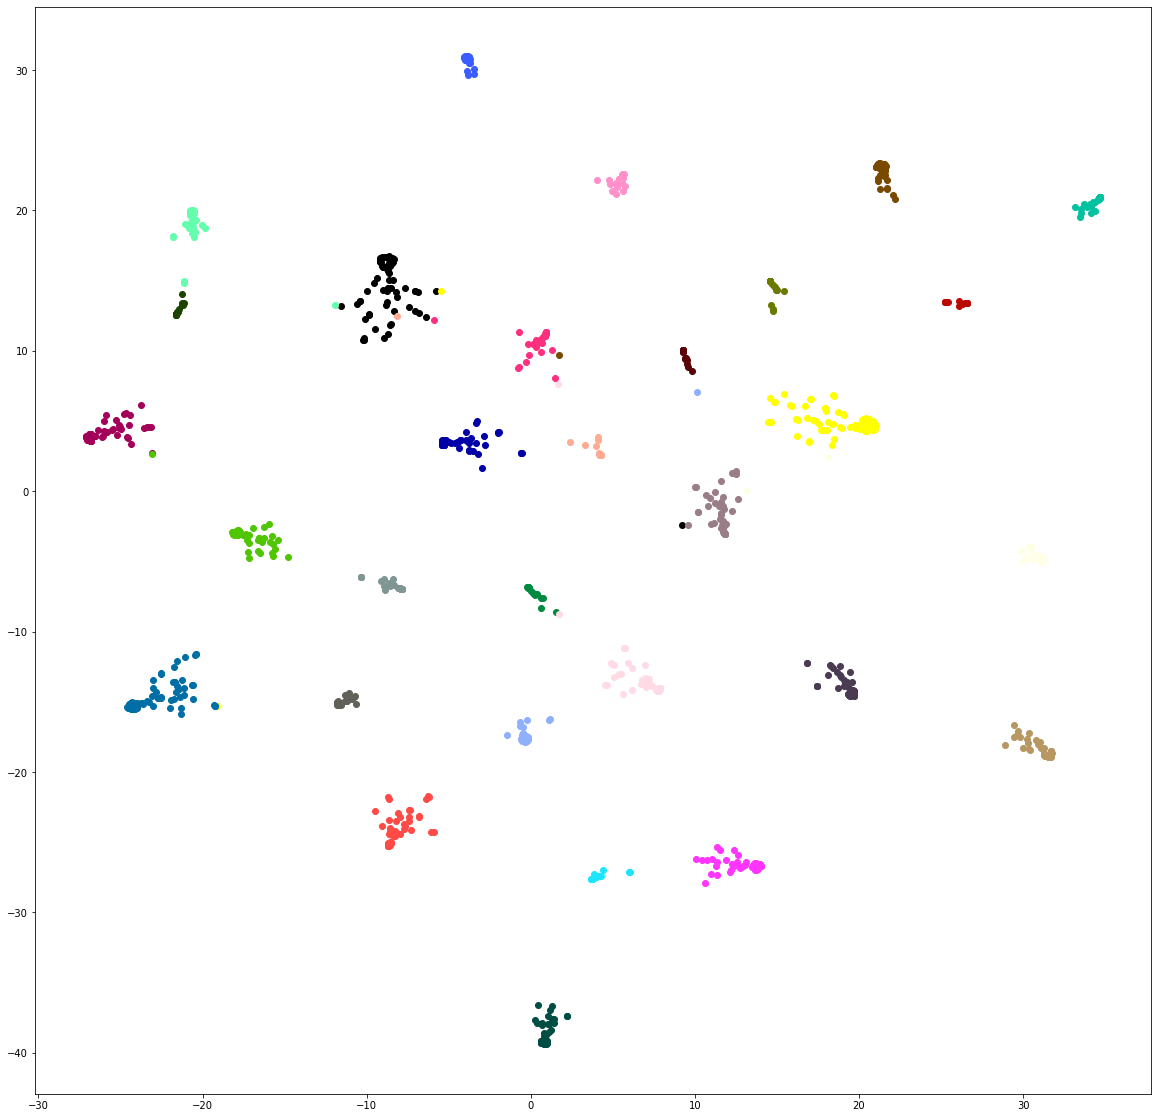

In [ ]:
visualize_clusters(num_topics, kmeans_text_freqs, colors, kmeans_labels, kmeans_title, titles)

<iframe title="[ Insert title here ]" aria-label="Scatter Plot" id="datawrapper-chart-65fwV" src="https://datawrapper.dwcdn.net/65fwV/1/" scrolling="no" frameborder="0" style="width: 0; min-width: 100% !important; border: none;" height="607" data-external="1"></iframe><script type="text/javascript">!function(){"use strict";window.addEventListener("message",(function(e){if(void 0!==e.data["datawrapper-height"]){var t=document.querySelectorAll("iframe");for(var a in e.data["datawrapper-height"])for(var r=0;r<t.length;r++){if(t[r].contentWindow===e.source)t[r].style.height=e.data["datawrapper-height"][a]+"px"}}}))}();
</script>

<iframe title="Topic visualization" aria-label="Scatter Plot" id="datawrapper-chart-65fwV" src="https://datawrapper.dwcdn.net/65fwV/2/" scrolling="no" frameborder="0" style="width: 0; min-width: 100% !important; border: none;" height="640" data-external="1"></iframe><script type="text/javascript">!function(){"use strict";window.addEventListener("message",(function(e){if(void 0!==e.data["datawrapper-height"]){var t=document.querySelectorAll("iframe");for(var a in e.data["datawrapper-height"])for(var r=0;r<t.length;r++){if(t[r].contentWindow===e.source)t[r].style.height=e.data["datawrapper-height"][a]+"px"}}}))}();
</script>

<iframe title="Presidential Approval Ratings Since Kennedy" aria-label="Interactive line chart" id="datawrapper-chart-t4fiQ" src="https://datawrapper.dwcdn.net/t4fiQ/3/" scrolling="no" frameborder="0" style="border: none;" width="600" height="578"></iframe>

<iframe title="30 topics" aria-label="Scatter Plot" id="datawrapper-chart-fWUIR" src="https://datawrapper.dwcdn.net/fWUIR/1/" scrolling="no" frameborder="0" style="width: 0; min-width: 100% !important; border: none;" height="720"></iframe><script type="text/javascript">!function(){"use strict";window.addEventListener("message",(function(e){if(void 0!==e.data["datawrapper-height"]){var t=document.querySelectorAll("iframe");for(var a in e.data["datawrapper-height"])for(var r=0;r<t.length;r++){if(t[r].contentWindow===e.source)t[r].style.height=e.data["datawrapper-height"][a]+"px"}}}))}();
</script>

## Save model


In [ ]:
lda_model_bert.save(Path + '/ldabert.model')
pickle.dump(kmeans, open(Path + "/kmeans_model.pkl", "wb"))

## Datawrapper visualization (for the best experiment)
Link here: https://datawrapper.dwcdn.net/fWUIR/1/